In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import glob
import pickle
import numpy as np
from scipy.stats import norm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import xesmf as xe

from tonic.io import read_configobj

from analysis_utils import (setup_output_dirs, to_netcdf_history_file_compress,
                            add_gridlines, edges_from_centers, map_ind_2D_to_1D,
                            map_ind_1D_to_2D, remap_con, find_global_param_value,
                            determine_tile_frac)

In [3]:
# ================================================ #
# Command line arguments
# ================================================ #
cfg = read_configobj('/civil/hydro/ymao/data_assim/tools/plot_analyze_results/cfg/' \
                     '20180627.ArkRed.smap.LAI_from_veglib.qc_with_winter.prec_1.sm_pert_spatial_corr/' \
                     'plot.EnKF_results.sm_0.5.prec_1.N32.cfg')

In [4]:
# ================================================ #
# Parameter setting
# ================================================ #
start_time = pd.to_datetime(cfg['EnKF']['start_time'])
end_time = pd.to_datetime(cfg['EnKF']['end_time'])
start_year = start_time.year
end_year = end_time.year

# Updated states directory, concatenated
# File name: updated_state_cellAvg.<YYYYMMDD>_<YYYYMMDD>.ens<i>.nc
updated_state_dir = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'states', 'updated_concat')

# EnKF output history dir
EnKF_hist_dir = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'history', 'EnKF_ensemble_concat')

# Ensemble size
N = cfg['EnKF']['N']

# Openloop history nc
hist_openloop_nc = os.path.join(cfg['EnKF']['openloop_basedir'],
                    'history', 'history.openloop.2015-03-31-00000.nc')

# Measurement nc
meas_nc = cfg['EnKF']['meas_nc']
#meas_unscaled_nc = cfg['EnKF']['meas_unscaled_nc']

# Weight nc
#weight_nc = cfg['EnKF']['weight_nc']

# # Time series grid cell
# lat_ind = 7 # 6  # index starts from 0
# lon_ind = 1 # 3
# # Corresponding SMAP cell (remember that SMAP lat is inversed)
# lat_ind_smap = 1
# lon_ind_smap = 1

# Output
output_rootdir = cfg['OUTPUT']['output_dir']

In [5]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']
output_maps_dir = setup_output_dirs(
                    output_rootdir,
                    mkdirs=['maps'])['maps']
output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [6]:
# ================================================ #
# Load data
# ================================================ #
print('Loading data...')
# --- Load openloop --- #
print('Openloop...')
ds_hist_openloop = xr.open_dataset(hist_openloop_nc)
#ds_hist_openloop_orig.load()
#ds_hist_openloop_orig.close()
times_correct = [pd.to_datetime(t) + pd.DateOffset(seconds=3600*3) for t in ds_hist_openloop['time'].values]
ds_hist_openloop['time'] = times_correct

# --- Measurement --- #
print('Measurement...')
da_meas = xr.open_dataset(meas_nc)['soil_moisture']
#da_meas.load()
#da_meas.close()

Loading data...
Openloop...
Measurement...


In [11]:
# --- Load updated states --- #
print('Updated states...')
out_nc = os.path.join(output_data_dir, 'updated_states.allEns.nc')
if not os.path.isfile(out_nc):  # if the all-ens state file not existed
    list_ds_updated_states = []
    for i in range(N):
        print(i)
        ds = xr.open_dataset(os.path.join(
            updated_state_dir,
            'updated_state_cellAvg.{}_{}.ens{}.nc'.format(
                start_time.strftime('%Y%m%d'), end_time.strftime('%Y%m%d'), i+1)))
        ds.load()
        ds.close()
        list_ds_updated_states.append(ds)
    ds_updated_states_allEns = xr.concat(list_ds_updated_states, dim='N')
    ds_updated_states_allEns.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:  # if file alreay existed
    ds_updated_states_allEns = xr.open_dataset(out_nc)

Updated states...
0


FileNotFoundError: [Errno 2] No such file or directory: b'/civil/hydro/ymao/data_assim/output/EnKF/ArkRed.smap/GPM.LAI_from_veglib.smap_with_winter_longtermRescale/prec_std1_phi0/sm_0.5_spatial_corr.N32.no_sm3_update_only/states/updated_concat/updated_state_cellAvg.20150331_20171231.ens1.nc'

In [ ]:
# --- Load EnKF output history files --- # !!! BETTER TO NOT USE HISTORY FILE TO GET UPDATED STATES !!!
print('EnKF hist to get updated SM...')
output_sm_hist_dir = setup_output_dirs(
        output_data_dir,
        mkdirs=['soil_moisture.from_EnKF_hist'])['soil_moisture.from_EnKF_hist']

list_da_updated_states = []
for i in range(N):
    print(i)
    out_nc = os.path.join(output_sm_hist_dir, 'ens_{}.nc'.format(i+1))
    if not os.path.isfile(out_nc):  # if concatenated history file not already existed
        list_da_all_years = []
        for year in range(start_year, end_year+1):
            da = xr.open_dataset(os.path.join(
                EnKF_hist_dir, 'history.ens{}.concat.{}.nc'.format(i+1, year)))['OUT_SOIL_MOIST']
            list_da_all_years.append(da)
        da_all_years = xr.concat(list_da_all_years, dim='time')
        ds_all_years = xr.Dataset({'OUT_SOIL_MOIST': da_all_years})
        to_netcdf_history_file_compress(ds_all_years, out_nc)
    else:  # if concatenated history file already existed
        da_all_years = xr.open_dataset(out_nc)['OUT_SOIL_MOIST']
    
    list_da_updated_states.append(da_all_years)
# Correct time
times_correct = [pd.to_datetime(t) + pd.DateOffset(seconds=3600*3) for t in list_da_updated_states[0]['time'].values]
for i in range(N):
    list_da_updated_states[i]['time'] = times_correct
# Concatenate
da_updated_states_allEns_from_hist = xr.concat(list_da_updated_states, dim='N')

In [ ]:
# --- Load reference hist file --- #
print('Reference history file...')
list_allyear = []
for year in range(start_year, end_year+1):
    ds = xr.open_dataset(os.path.join(
        EnKF_hist_dir, 'history.ensref.concat.{}.nc'.format(year)))
    list_allyear.append(ds)
ds_ref_hist = xr.concat(list_allyear, dim='time')
# Fix time index
times_correct = [pd.to_datetime(t) + pd.DateOffset(seconds=3600*3) for t in ds_ref_hist['time'].values]
ds_ref_hist['time'] = times_correct

## Average VIC-resolution results to SMAP resolution

In [ ]:
# Remap openloop soil moisture
da_openloop_remapped, weight_array = remap_con(
    reuse_weight=True,
    da_source=ds_hist_openloop['OUT_SOIL_MOIST'],
    final_weight_nc=cfg['EnKF']['weight_nc'],
    da_target_domain=da_meas,
    da_source_domain=xr.open_dataset(cfg['EnKF']['domain_nc'])['mask'],
    tmp_weight_nc=None, process_method=None)
# Ensemble updated states
da_updated_states_allEns_remapped, weight_array = remap_con(
    reuse_weight=True,
    da_source=ds_updated_states_allEns['SOIL_MOISTURE'],
    final_weight_nc=cfg['EnKF']['weight_nc'],
    da_target_domain=da_meas,
    da_source_domain=xr.open_dataset(cfg['EnKF']['domain_nc'])['mask'],
    tmp_weight_nc=None, process_method=None)

## Plot innovation

In [ ]:
da_meas['lon'][31]

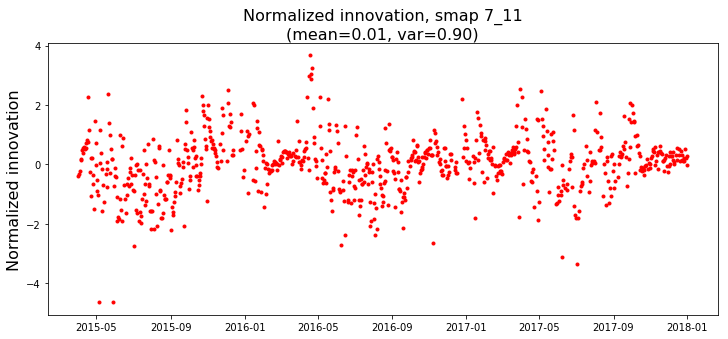

In [7]:
# ================================================ #
# Plot innovation time series
# ================================================ #
lat_ind_smap = 7
lon_ind_smap = 11

# --- Load normalized innovation --- #
innov_nc = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'innov',
                        'innov_norm.concat.{}_{}.nc'.format(start_year, end_year))
da_innov_norm = xr.open_dataset(innov_nc)['innov_norm']
da_innov_norm.load()
da_innov_norm.close()

# --- Plot time series for one grid cell --- #
fig = plt.figure(figsize=(12, 5))
ts_innov = da_innov_norm[:, lat_ind_smap, lon_ind_smap].to_series()
plt.plot(ts_innov, 'r.')
# Make plot looks better
plt.ylabel('Normalized innovation', fontsize='16')
plt.xlabel('')
plt.title(
    'Normalized innovation, smap {}_{}\n(mean={:.2f}, var={:.2f})'.format(
        lat_ind_smap, lon_ind_smap,
        ts_innov.mean(), ts_innov.var()),
    fontsize=16)
# Save
fig.savefig(os.path.join(
    output_ts_dir,
    'smap.{}_{}.innov_norm.'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


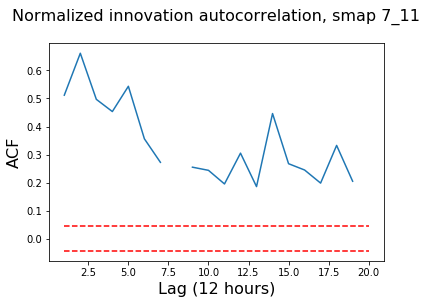

In [8]:
# --- Plot ACF --- #
lag_max = 20 # int(len(ts_innov) / 2)
list_acf = []
for h in range(1, lag_max):
    df = pd.DataFrame(np.column_stack((ts_innov[:-h].values, ts_innov[h:].values)),
                      columns=['a', 'b']).dropna()
    acf = np.corrcoef(df.loc[:, 'a'], df.loc[:, 'b'])[0, 1]
    list_acf.append(acf)
conf_level = norm.ppf(0.975) / np.sqrt(len(ts_innov))  # 95% confidence interval
fig = plt.figure()
plt.plot(range(1, lag_max), list_acf)
plt.plot([1, lag_max], [conf_level, conf_level], 'r--')
plt.plot([1, lag_max], [-conf_level, -conf_level], 'r--')
plt.xlabel('Lag (12 hours)', fontsize=16)
plt.ylabel('ACF', fontsize=16)
plt.title(
    'Normalized innovation autocorrelation, smap {}_{}\n'.format(
        lat_ind_smap, lon_ind_smap,),
    fontsize=16)
# Save
fig.savefig(
    os.path.join(
        output_ts_dir,
        'smap.{}_{}.innov_norm_acf.'.format(lat_ind_smap, lon_ind_smap)),
    forma='png', bbox_inches='tight', pad_inches=0)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


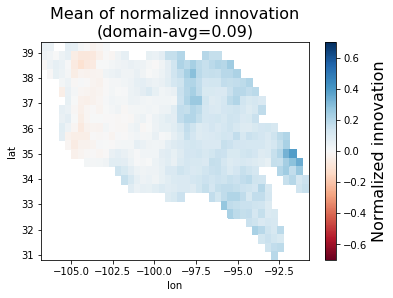

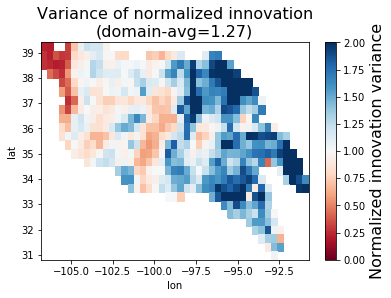

In [9]:
# --- Plot map - innovation mean --- #
# --- Load normalized innovation --- #
innov_nc = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'innov',
                        'innov_norm.concat.{}_{}.nc'.format(start_year, end_year))
da_innov_norm = xr.open_dataset(innov_nc)['innov_norm']
da_innov_norm.load()
da_innov_norm.close()

fig = plt.figure()
cs = da_innov_norm.mean(dim='time').plot(add_colorbar=False, vmin=-0.7, vmax=0.7, cmap='RdBu')
cbar = plt.colorbar(cs)
cbar.set_label('Normalized innovation', fontsize=16)
plt.title(
    'Mean of normalized innovation\n(domain-avg={:.2f})'.format(
        float(da_innov_norm.mean(dim='time').mean().values)),
    fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.innov_norm_mean.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- Plot map - innovation variance --- #
fig = plt.figure()
cs = da_innov_norm.var(dim='time').plot(add_colorbar=False,
                                        vmin=0, vmax=2, cmap='RdBu')
cbar = plt.colorbar(cs)
cbar.set_label('Normalized innovation variance', fontsize=16)
plt.title(
    'Variance of normalized innovation\n(domain-avg={:.2f})'.format(
        float(da_innov_norm.var(dim='time').mean().values)),
    fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.innov_norm_var.png'), format='png',
            bbox_inches='tight', pad_inches=0)

## Plot maps

NameError: name 'ds_updated_states_allEns' is not defined

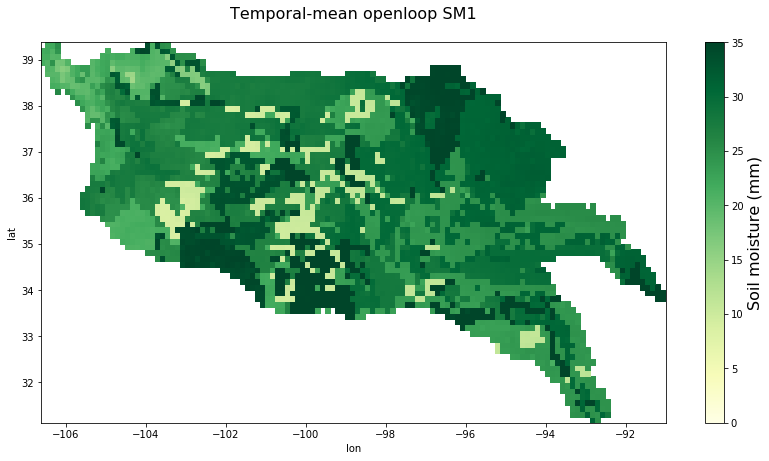

In [10]:
# --- Temporal mean openloop SM1 --- #
da_sm1_openloop_mean = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0).mean(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_sm1_openloop_mean.plot(add_colorbar=False, cmap='YlGn', vmin=0, vmax=35)
cbar = plt.colorbar(cs)
cbar.set_label('Soil moisture (mm)', fontsize=16)
plt.title('Temporal-mean openloop SM1\n', fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.openloop.sm1.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- Temporal mean openloop SM1 --- #
da_sm1_updated_mean = ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=0).mean(dim='N').mean(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_sm1_updated_mean.plot(add_colorbar=False, cmap='YlGn', vmin=0, vmax=35)
cbar = plt.colorbar(cs)
cbar.set_label('Soil moisture (mm)', fontsize=16)
plt.title('Ensemble-Temporal-mean openloop SM1\n', fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.updated_ensMean.sm1.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- Difference --- #
da_sm1_mean_diff = (ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=0).mean(dim='N') - \
    ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0)).mean(dim='time')
#da_sm1_mean_diff = da_sm1_updated_mean - da_sm1_openloop_mean
fig = plt.figure(figsize=(14, 7))
cs = da_sm1_mean_diff.plot(add_colorbar=False, cmap='RdBu', vmin=-1.5, vmax=1.5)
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture difference (mm)', fontsize=16)
plt.title('SM1 difference (updated - openloop)\n', fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.sm1.diff.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- Difference with SMAP grids - this is for diagnosis --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([float(da_meas['lon'].min().values) - 0.5,
               float(da_meas['lon'].max().values) + 0.5,
               float(da_meas['lat'].min().values) - 0.5,
               float(da_meas['lat'].max().values) + 0.5], ccrs.Geodetic())
gl = add_gridlines(
    ax,
    xlocs=np.arange(float(da_meas['lon'].min().values) -0.5,
                    float(da_meas['lon'].max().values) +0.5, 2),
                    ylocs=np.arange(
                        float(da_meas['lat'].min().values) - 0.5,
                        float(da_meas['lat'].max().values) + 0.5, 2), alpha=0)
# Plot difference
cs = da_sm1_mean_diff.plot(
    add_colorbar=False, cmap='RdBu',
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-2, vmax=2)
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture difference (mm)', fontsize=16)
plt.title('SM1 difference (updated - openloop)\n', fontsize=16)
# Plot SMAP grids
lon_edges = edges_from_centers(da_meas['lon'].values)
lat_edges = edges_from_centers(da_meas['lat'].values)
lonlon, latlat = np.meshgrid(lon_edges, lat_edges)
cs = plt.pcolormesh(
    lonlon, latlat, (da_meas[0, :, :]>=0).values,
    cmap='jet',
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),
    facecolor='none',
    edgecolor=(1, 0, 0, 0.5),
    linewidth=0.05)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.sm1.diff.with_grid.png'), format='png',
            bbox_inches='tight', pad_inches=0)

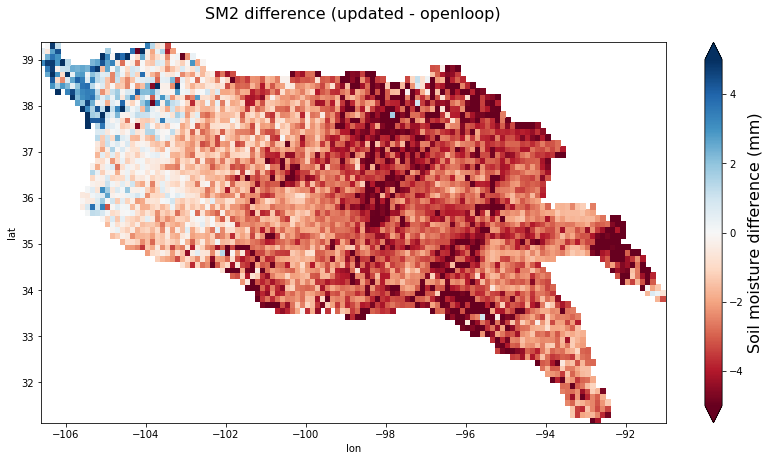

In [15]:
# --- Difference, SM2 --- #
da_sm2_mean_diff = (ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=1).mean(dim='N') - \
    ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=1)).mean(dim='time')
#da_sm1_mean_diff = da_sm1_updated_mean - da_sm1_openloop_mean
fig = plt.figure(figsize=(14, 7))
cs = da_sm2_mean_diff.plot(add_colorbar=False, cmap='RdBu', vmin=-5, vmax=5)
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture difference (mm)', fontsize=16)
plt.title('SM2 difference (updated - openloop)\n', fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.sm2.diff.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# # --- Difference with SMAP grids - this is for diagnosis --- #
# fig = plt.figure(figsize=(14, 7))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([float(da_meas['lon'].min().values) - 0.5,
#                float(da_meas['lon'].max().values) + 0.5,
#                float(da_meas['lat'].min().values) - 0.5,
#                float(da_meas['lat'].max().values) + 0.5], ccrs.Geodetic())
# gl = add_gridlines(
#     ax,
#     xlocs=np.arange(float(da_meas['lon'].min().values) -0.5,
#                     float(da_meas['lon'].max().values) +0.5, 2),
#                     ylocs=np.arange(
#                         float(da_meas['lat'].min().values) - 0.5,
#                         float(da_meas['lat'].max().values) + 0.5, 2), alpha=0)
# # Plot difference
# cs = da_sm2_mean_diff.plot(
#     add_colorbar=False, cmap='RdBu',
#     ax=ax,
#     transform=ccrs.PlateCarree())
# cbar = plt.colorbar(cs, extend='both')
# cbar.set_label('Soil moisture difference (mm)', fontsize=16)
# plt.title('SM2 difference (updated - openloop)\n', fontsize=16)
# # Plot SMAP grids
# lon_edges = edges_from_centers(da_meas['lon'].values)
# lat_edges = edges_from_centers(da_meas['lat'].values)
# lonlon, latlat = np.meshgrid(lon_edges, lat_edges)
# cs = plt.pcolormesh(
#     lonlon, latlat, (da_meas[0, :, :]>=0).values,
#     cmap='jet',
#     vmin=0, vmax=1,
#     transform=ccrs.PlateCarree(),
#     facecolor='none',
#     edgecolor=(1, 0, 0, 0.5),
#     linewidth=0.05)
# # Save
# fig.savefig(os.path.join(output_maps_dir, 'map.sm2.diff.with_grid.png'), format='png',
#             bbox_inches='tight', pad_inches=0)

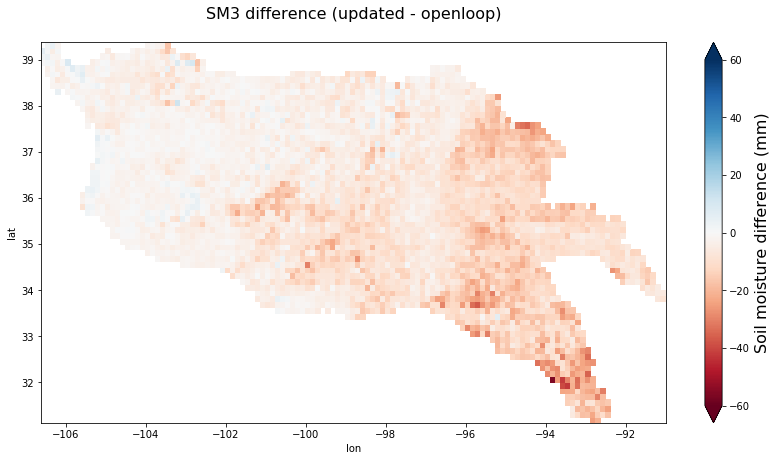

In [17]:
# --- Difference, SM3 --- #
da_sm3_mean_diff = (ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=2).mean(dim='N') - \
    ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=2)).mean(dim='time')
#da_sm1_mean_diff = da_sm1_updated_mean - da_sm1_openloop_mean
fig = plt.figure(figsize=(14, 7))
cs = da_sm3_mean_diff.plot(add_colorbar=False, cmap='RdBu', vmin=-60, vmax=60)
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture difference (mm)', fontsize=16)
plt.title('SM3 difference (updated - openloop)\n', fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.sm3.diff.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# # --- Difference with SMAP grids - this is for diagnosis --- #
# fig = plt.figure(figsize=(14, 7))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([float(da_meas['lon'].min().values) - 0.5,
#                float(da_meas['lon'].max().values) + 0.5,
#                float(da_meas['lat'].min().values) - 0.5,
#                float(da_meas['lat'].max().values) + 0.5], ccrs.Geodetic())
# gl = add_gridlines(
#     ax,
#     xlocs=np.arange(float(da_meas['lon'].min().values) -0.5,
#                     float(da_meas['lon'].max().values) +0.5, 2),
#                     ylocs=np.arange(
#                         float(da_meas['lat'].min().values) - 0.5,
#                         float(da_meas['lat'].max().values) + 0.5, 2), alpha=0)
# # Plot difference
# cs = da_sm3_mean_diff.plot(
#     add_colorbar=False, cmap='RdBu',
#     ax=ax,
#     transform=ccrs.PlateCarree())
# cbar = plt.colorbar(cs, extend='both')
# cbar.set_label('Soil moisture difference (mm)', fontsize=16)
# plt.title('SM3 difference (updated - openloop)\n', fontsize=16)
# # Plot SMAP grids
# lon_edges = edges_from_centers(da_meas['lon'].values)
# lat_edges = edges_from_centers(da_meas['lat'].values)
# lonlon, latlat = np.meshgrid(lon_edges, lat_edges)
# cs = plt.pcolormesh(
#     lonlon, latlat, (da_meas[0, :, :]>=0).values,
#     cmap='jet',
#     vmin=0, vmax=1,
#     transform=ccrs.PlateCarree(),
#     facecolor='none',
#     edgecolor=(1, 0, 0, 0.5),
#     linewidth=0.05)
# # Save
# fig.savefig(os.path.join(output_maps_dir, 'map.sm3.diff.with_grid.png'), format='png',
#             bbox_inches='tight', pad_inches=0)

## Investigate weights

In [ ]:
with open('/civil/hydro/ymao/data_assim/src/list_source_ind2D_weight_all.pickle', 'rb') as f:
    list_source_ind2D_weight_all = pickle.load(f)

In [ ]:
len(list_source_ind2D_weight_all)

In [ ]:
n_contrib = len(list_source_ind2D_weight_all[9])
list_source_ind2D_weight_all[9][3]

In [ ]:
for item in list_source_ind2D_weight_all[8]:
    print(item[0])
    break

## Plot time series

In [23]:
# Specify lat lon to plot (34.5625, -100.9375)
lat = 34.6875
lon = -94.9375

# Find lat lon index
lat_ind = np.where(ds_hist_openloop['lat'].values==lat)[0][0]
lon_ind = np.where(ds_hist_openloop['lon'].values==lon)[0][0]
# Load weight array
A = xe.frontend.read_weights(
    cfg['EnKF']['weight_nc'],
    len(ds_hist_openloop['lat'])*len(ds_hist_openloop['lon']),
    len(da_meas['lat'])*len(da_meas['lon']))
weight_array = A.toarray()  # [n_target, n_source]
# Find weights of this VIC grid cell
vic_cell_ind1D = map_ind_2D_to_1D(lat_ind, lon_ind, len(ds_hist_openloop['lon']))
all_weights_vic_cell = weight_array[:, vic_cell_ind1D]
smap_cell_ind1D_array = np.where(all_weights_vic_cell>0)
# Find the SMAP grid cell that contributes the most to the VIC cell
n_cell_split = len(smap_cell_ind1D_array[0])  # the number of SMAP cells that the VIC cell spans
smap_ind1D_max = np.argmax(all_weights_vic_cell)
lat_ind_smap_max, lon_ind_smap_max = map_ind_1D_to_2D(smap_ind1D_max, len(da_meas['lon']))
print(n_cell_split)
# Find all overlapping SMAP grid cells
list_smap_ind1D = np.where(all_weights_vic_cell>0)[0]
list_in2D_smap = [map_ind_1D_to_2D(smap_ind1D, len(da_meas['lon'])) for smap_ind1D in list_smap_ind1D]
colors = ['orange', 'pink', 'tan', 'yellow']

1


In [ ]:
lon_ind_smap_max

In [29]:
lat_ind_smap_max, lon_ind_smap_max

(7, 11)

In [30]:
lat_ind = 0
lon_ind = 0
lat_ind_smap = 0
lon_ind_smap = 0
n_cell_split = 1
list_in2D_smap = [(0, 0)]
lat_ind_smap_max = 0
lon_ind_smap_max = 0
lat = float(ds_hist_openloop['lat'].values)
lon = float(ds_hist_openloop['lon'].values)

TypeError: only size-1 arrays can be converted to Python scalars

red


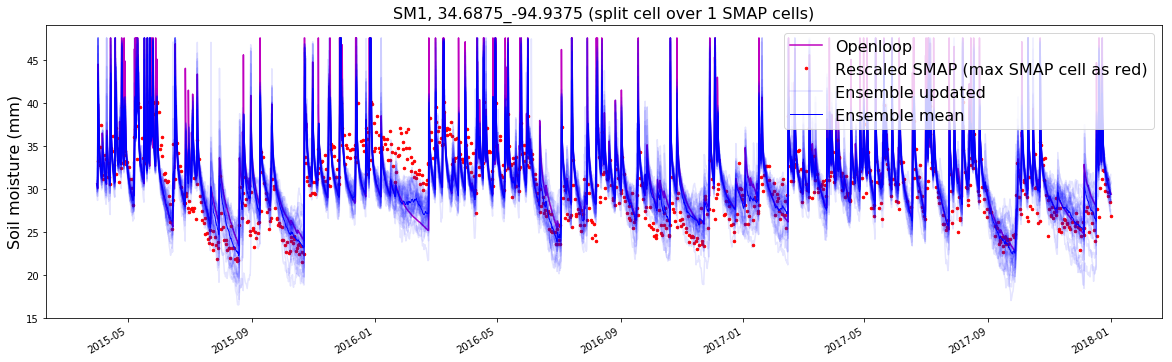

In [24]:
# ================================================ #
# Plot time series
# ================================================ #
# Time series grid cell
# lat_ind = 56 # index starts from 0
# lon_ind = 17
# lat = ds_hist_openloop['lat'][lat_ind].values
# lon = ds_hist_openloop['lon'][lon_ind].values
# # Corresponding SMAP cell (remember that SMAP lat is inversed)
# lat_ind_smap = 3
# lon_ind_smap = 6

# --- Plot SM1 --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Measurements
for i, (lat_ind_smap, lon_ind_smap) in enumerate(list_in2D_smap):
    ts_meas = da_meas[:, lat_ind_smap, lon_ind_smap].to_series()
    label = 'Rescaled SMAP (max SMAP cell as red)' if i == 0 else '_nolegend_'
    if lat_ind_smap == lat_ind_smap_max and lon_ind_smap == lon_ind_smap_max:
        color = 'red'
    else:
        color = colors[i]
    print(color)
    ts_meas.plot(color=color, style='.', markersize=5, label=label)
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.1, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
## Reference run
#ts_ref = ds_ref_hist['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
#plt.plot(ts_ref, color='orange', linestyle='--', label='Reference run')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'SM1, {}_{} (split cell over {} SMAP cells)'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values,
        n_cell_split),
    fontsize=16)
#plt.xlim([pd.to_datetime('2015-03-31'), pd.to_datetime('2015-12-31')])
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.sm1.png'.format(ds_hist_openloop['lat'][lat_ind].values,
                          ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [40]:
lat_ind_smap = lat_ind_smap_max
lon_ind_smap = lon_ind_smap_max

In [41]:
lat_ind_smap, lon_ind_smap

(13, 15)

KeyboardInterrupt: 

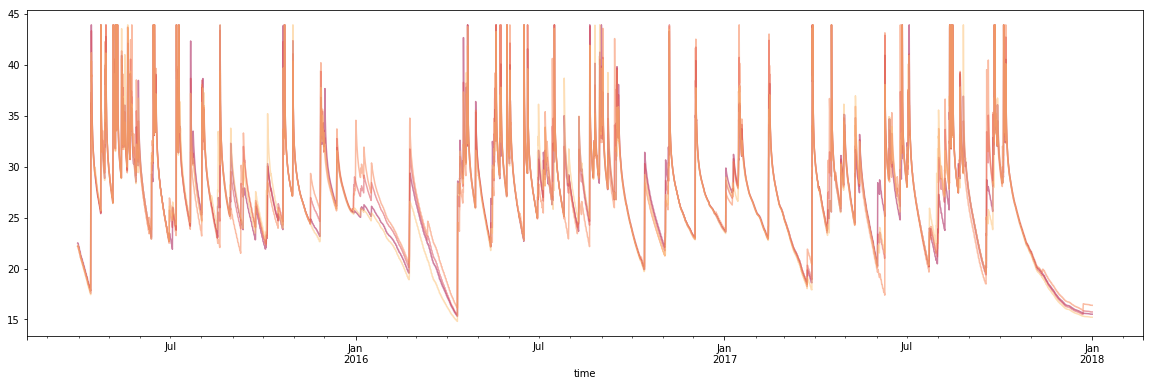

In [42]:
# --- Plot SM1 - SMAP and all corresponding VIC cells --- #
smap_ind1D = map_ind_2D_to_1D(lat_ind_smap, lon_ind_smap, len(da_meas['lon']))
list_vic_ind1D = np.where(weight_array[smap_ind1D, :]>0)[0]
# --- Openloop only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
cmap = matplotlib.cm.get_cmap('Spectral')
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, openloop' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Measurements
ts_meas = da_meas[:, lat_ind_smap, lon_ind_smap].to_series()
ts_meas.plot(color='red', style='.', markersize=5, label='Rescaled SMAP')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM1 openloop, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm1.openloop.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

# --- Updated ensemble mean only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=0).mean('N')[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, updated ensemble mean' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Measurements
ts_meas = da_meas[:, lat_ind_smap, lon_ind_smap].to_series()
ts_meas.plot(color='red', style='.', markersize=5, label='Rescaled SMAP')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM1 updated ensemble mean, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm1.updated.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

In [43]:
# Interactive
output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
p = figure(title='SM1, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# plot EnKF updated states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
       legend="DA ensemble updated state", line_width=2)
p.line(ts_mean.index, ts_mean.values, color="blue", line_dash="solid")
# plot open-loop
p.line(ts_openloop.index, ts_openloop.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
## Reference
#p.line(ts_ref.index, ts_ref.values, color="orange", line_dash="dashed",
#       legend="Reference run", line_width=2)
# plot measurement
p.circle(ts_meas.index, ts_meas.values, color="red", fill_color="red",
         legend="Measurement", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180408.ArkRed.smap.NLDAS2.weight_no_split.qc_no_winter.meas_error_v2/sm_0.5.prec_0.3.N32.no_sm3/time_series/34.6875_-94.9375.sm1.html'

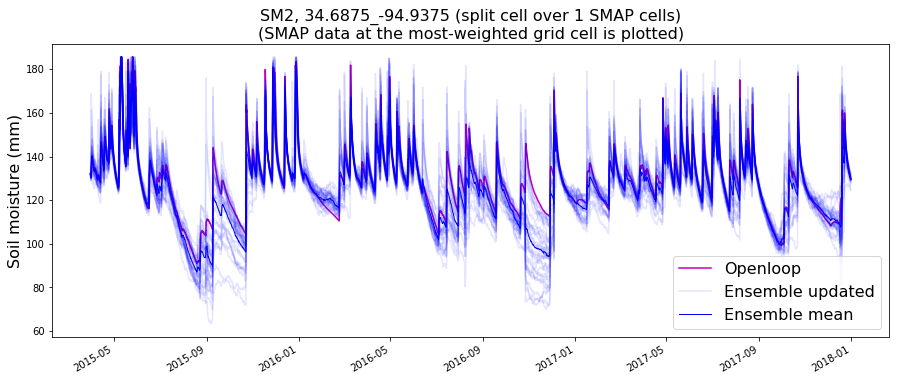

In [25]:
# --- Plot SM2 --- #
fig = plt.figure(figsize=(15, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.1, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'SM2, {}_{} (split cell over {} SMAP cells)\n(SMAP data at the most-weighted grid cell is plotted)'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values,
        n_cell_split),
    fontsize=16)
# Save
fig.savefig(os.path.join(
    output_ts_dir,
    '{}_{}.sm2.'.format(ds_hist_openloop['lat'][lat_ind].values,
                        ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
(ts_mean - ts_openloop).mean()

In [ ]:
# --- Plot SM2 - remapped to SMAP grid cell!! --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
ts_openloop = da_openloop_remapped.sel(nlayer=1)[:, lat_ind_smap, lon_ind_smap].to_series()
ts_openloop.plot(color='m', style='-', label='Openloop')
# Updated ensemble states
ts_mean = da_updated_states_allEns_remapped.mean(dim='N').sel(nlayer=1)[:, lat_ind_smap, lon_ind_smap].to_series()
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'SM2, {}_{}, remapped to SMAP resolution'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values),
    fontsize=16)
# Save
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm2.remapped_to_smap.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot SM2 - SMAP and all corresponding VIC cells --- #
smap_ind1D = map_ind_2D_to_1D(lat_ind_smap, lon_ind_smap, len(da_meas['lon']))
list_vic_ind1D = np.where(weight_array[smap_ind1D, :]>0)[0]
# --- Openloop only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
cmap = matplotlib.cm.get_cmap('Spectral')
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=1)[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, openloop' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM2 openloop, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm2.openloop.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

# --- Updated ensemble mean only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=1).mean('N')[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, updated ensemble mean' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM2 updated ensemble mean, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm2.updated.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

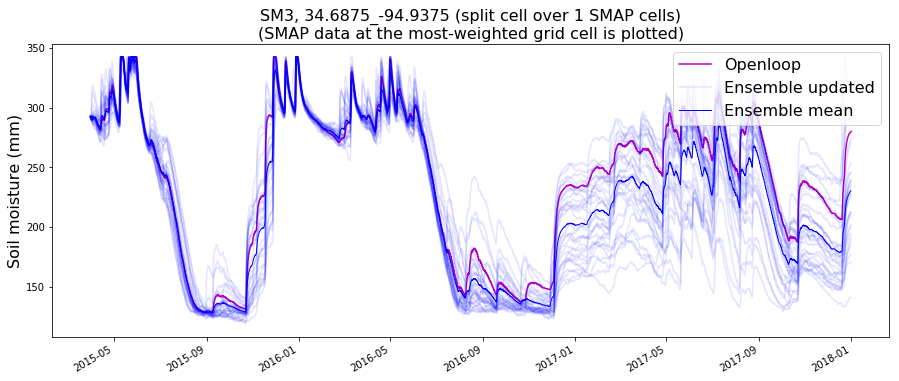

In [26]:
# --- Plot SM3 --- #
fig = plt.figure(figsize=(15, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.1, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'SM3, {}_{} (split cell over {} SMAP cells)\n(SMAP data at the most-weighted grid cell is plotted)'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values,
        n_cell_split),
    fontsize=16)
# Save
fig.savefig(os.path.join(
    output_ts_dir,
    '{}_{}.sm3.'.format(ds_hist_openloop['lat'][lat_ind].values,
                        ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot SM3 - remapped to SMAP grid cell!! --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
ts_openloop = da_openloop_remapped.sel(nlayer=2)[:, lat_ind_smap, lon_ind_smap].to_series()
ts_openloop.plot(color='m', style='-', label='Openloop')
# Updated ensemble states
ts_mean = da_updated_states_allEns_remapped.mean(dim='N').sel(nlayer=2)[:, lat_ind_smap, lon_ind_smap].to_series()
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'SM3, {}_{}, remapped to SMAP resolution'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values),
    fontsize=16)
# Save
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm3.remapped_to_smap.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot SM3 - SMAP and all corresponding VIC cells --- #
smap_ind1D = map_ind_2D_to_1D(lat_ind_smap, lon_ind_smap, len(da_meas['lon']))
list_vic_ind1D = np.where(weight_array[smap_ind1D, :]>0)[0]
# --- Openloop only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
cmap = matplotlib.cm.get_cmap('Spectral')
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=2)[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, openloop' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM3 openloop, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm3.openloop.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

# --- Updated ensemble mean only --- #
fig = plt.figure(figsize=(20, 6))
# Openloop of all VIC cells
for i in range(len(list_vic_ind1D)):
    color = cmap(i / len(list_vic_ind1D))
    lat_ind_tmp, lon_ind_tmp = map_ind_1D_to_2D(list_vic_ind1D[i], len(ds_hist_openloop['lon']))
    ts = ds_updated_states_allEns['SOIL_MOISTURE'].sel(nlayer=2).mean('N')[:, lat_ind_tmp, lon_ind_tmp].to_series()
    label = 'Individual VIC grid cell, updated ensemble mean' if i == 0 else '_nolegend_'
    ts.plot(color=color, style='-', label=label, alpha=0.5)
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title('SM3 updated ensemble mean, smap cell ID: ({}, {})'.format(lat_ind_smap, lon_ind_smap))
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   'smap.{}_{}.sm3.updated.png'.format(lat_ind_smap, lon_ind_smap)),
           bbox_inches='tight', pad_inches=0)

## One-cell experiment

In [ ]:
lat_ind = 0
lon_ind = 0
lat_ind_smap = 0
lon_ind_smap = 0
lat = ds_hist_openloop['lat'][lat_ind].values
lon = ds_hist_openloop['lon'][lat_ind].values

In [ ]:
# --- Plot SM1 --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Measurements
ts_meas = da_meas[:, lat_ind_smap, lon_ind_smap].to_series()
ts_meas.plot(color='red', style='.', markersize=5, label='Rescaled SMAP')
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.05, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# # Reference run
# ts_ref = ds_ref_hist['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
# plt.plot(ts_ref, color='orange', linestyle='--', label='Reference run')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'One-cell expreiment, SM1, {}_{}'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values),
    fontsize=16)
#plt.xlim([pd.to_datetime('2015-03-31'), pd.to_datetime('2015-12-31')])
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.sm1.png'.format(ds_hist_openloop['lat'][lat_ind].values,
                          ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
p = figure(title='SM1, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# plot EnKF updated states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
       legend="DA ensemble updated state", line_width=2)
p.line(ts_mean.index, ts_mean.values, color="blue", line_dash="solid")
# plot open-loop
p.line(ts_openloop.index, ts_openloop.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# # Reference run
# p.line(ts_ref.index, ts_ref.values, color="orange", line_dash="dashed",
#        legend="Reference run", line_width=2)
# plot measurement
p.circle(ts_meas.index, ts_meas.values, color="red", fill_color="red",
         legend="Measurement", line_width=2)
# Save
save(p)

In [ ]:
# --- Plot SMAP vs SM1 scatter plot --- #
ts_openloop_sm1 = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=0)[:, lat_ind, lon_ind].to_series()
ts_meas = da_meas[:, lat_ind_smap, lon_ind_smap].to_series()
# Make VIC sm1 consistent
ts_openloop_sm1 = ts_openloop_sm1[ts_meas.index]
ts_openloop_sm1[np.isnan(ts_meas)] = np.nan
# Plot scatter plot
fig = plt.figure(figsize=(8, 6))
plt.plot(ts_openloop_sm1, ts_meas, '.')
plt.xlabel('VIC openloop SM1 (mm)', fontsize=16)
plt.ylabel('SMAP rescaled (mm)', fontsize=16)
# Save figure
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.scatter_sm1_smap.png'.format(
       ds_hist_openloop['lat'][lat_ind].values,
       ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot SM2 --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.05, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# # Reference run
# ts_ref = ds_ref_hist['OUT_SOIL_MOIST'].sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
# plt.plot(ts_ref, color='orange', linestyle='--', label='Reference run')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'One-cell expreiment, SM2, {}_{}'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values),
    fontsize=16)
#plt.xlim([pd.to_datetime('2015-03-31'), pd.to_datetime('2015-12-31')])
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.sm2.png'.format(ds_hist_openloop['lat'][lat_ind].values,
                          ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.sm2.html'.format(lat, lon)))
p = figure(title='SM2, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# plot EnKF updated states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=1)[:, lat_ind, lon_ind].to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
       legend="DA ensemble updated state", line_width=2)
p.line(ts_mean.index, ts_mean.values, color="blue", line_dash="solid")
# plot open-loop
p.line(ts_openloop.index, ts_openloop.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# # Reference run
# p.line(ts_ref.index, ts_ref.values, color="orange", line_dash="dashed",
#        legend="Reference run", line_width=2)
# Save
save(p)

In [ ]:
# --- Plot SM3 --- #
fig = plt.figure(figsize=(20, 6))
# Openloop
da_hist_sm_openloop = ds_hist_openloop['OUT_SOIL_MOIST']
ts_openloop = ds_hist_openloop['OUT_SOIL_MOIST'].sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-', label='Openloop')
# Updated ensemble states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
    if i == 0:
        ts_mean = ts
    else:
        ts_mean += ts
    label = 'Ensemble updated' if i == 0 else '_nolegend_'
    ts.plot(color='b', style='-', alpha=0.05, label=label)
ts_mean = ts_mean / N
ts_mean.plot(color='b', style='-', lw=1, label='Ensemble mean')
# # Reference run
# ts_ref = ds_ref_hist['OUT_SOIL_MOIST'].sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
# plt.plot(ts_ref, color='orange', linestyle='--', label='Reference run')
# Make plot looks better
plt.legend(fontsize='16')
plt.ylabel('Soil moisture (mm)', fontsize='16')
plt.xlabel('')
plt.title(
    'One-cell expreiment, SM3, {}_{}'.format(
        ds_hist_openloop['lat'][lat_ind].values, ds_hist_openloop['lon'][lon_ind].values),
    fontsize=16)
#plt.xlim([pd.to_datetime('2015-03-31'), pd.to_datetime('2015-12-31')])
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.sm3.png'.format(ds_hist_openloop['lat'][lat_ind].values,
                          ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.sm3.html'.format(lat, lon)))
p = figure(title='SM3, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# plot EnKF updated states
for i in range(N):
    da_updated_states = ds_updated_states_allEns.sel(N=i)['SOIL_MOISTURE']
    ts = da_updated_states.sel(nlayer=2)[:, lat_ind, lon_ind].to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
       legend="DA ensemble updated state", line_width=2)
p.line(ts_mean.index, ts_mean.values, color="blue", line_dash="solid")
# plot open-loop
p.line(ts_openloop.index, ts_openloop.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# # Reference run
# p.line(ts_ref.index, ts_ref.values, color="orange", line_dash="dashed",
#        legend="Reference run", line_width=2)
# Save
save(p)

In [ ]:
fig = plt.figure(figsize=(20, 6))
(ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=0).std(dim='N').to_series()).plot(
    color='blue', label='Layer 1, updated')
da_updated_states_allEns_from_hist.squeeze().sel(nlayer=0).std(dim='N').to_series().plot(
    color='blue', style='--', label='Layer1, propogated')
(ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=1).std(dim='N').to_series()).plot(
    color='orange', label='Layer 2, updated')
da_updated_states_allEns_from_hist.squeeze().sel(nlayer=1).std(dim='N').to_series().plot(
    color='orange', style='--', label='Layer2, propogated')
(ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=2).std(dim='N').to_series()).plot(
    color='green', label='Layer 3, updated')
da_updated_states_allEns_from_hist.squeeze().sel(nlayer=2).std(dim='N').to_series().plot(
    color='green', style='--', label='Layer 3, propogated')
plt.legend(fontsize=16)
plt.ylabel('Soil moisture standard deviation (mm)', fontsize=16)
plt.title('Ensemble standard deviation of three layers of updated SM, {}, {}'.format(lat, lon), fontsize=16)
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.sm_std.png'.format(lat, lon)),
           bbox_inches='tight', pad_inches=0)

# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.sm_std.html'.format(lat, lon)))
p = figure(title='Ensemble standard deviation of three layers of updated SM, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moisture standard deviation (mm)",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_std = ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=0).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="blue", line_dash="solid",
       legend="Layer 1, updated", line_width=2)
ts_std = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=0).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="blue", line_dash="dashed",
       legend="Layer 1, propagated", line_width=2)
# Layer 2
ts_std = ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=1).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
ts_std = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=1).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="orange", line_dash="dashed",
       legend="Layer 2, propagated", line_width=2)
# Layer 3
ts_std = ds_updated_states_allEns['SOIL_MOISTURE'].squeeze().sel(nlayer=2).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
ts_std = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=2).std(dim='N').to_series()
p.line(ts_std.index, ts_std.values, color="green", line_dash="dashed",
       legend="Layer 3, propagated", line_width=2)
# Save
save(p)

# Diagnostic plots

In [ ]:
# ================================================ #
# Plot precipitation for diagnostics
# ================================================ #
# --- Load data --- #
# Load ensemble precipitation
list_da_prec = []
for i in range(N):
    list_da_prec_year = []
    for year in range(2015, 2018):
        force_nc = ('/civil/hydro/ymao/data_assim/output/ensemble_forcing/ArkRed.small/'
                    'random1.prec_std_0.5.NLDAS2.34.5625_-100.9375/ens_{}/force.{}.nc'.format(i+1, year))
        da_prec = xr.open_dataset(force_nc)['PREC']
        list_da_prec_year.append(da_prec)
    da_prec_allyears = xr.concat(list_da_prec_year, dim='time')
    list_da_prec.append(da_prec_allyears)
da_prec_allEns = xr.concat(list_da_prec, dim='N')
# Load openloop precipitation
list_da_prec_openloop = []
for year in range(2015, 2018):
    da_prec = xr.open_dataset(
        '/civil/hydro/ymao/data_assim/forcing/vic/NLDAS-2/ArkRed.small.34.5625_-100.9375/force.{}.nc'.format(year))['PREC']
    list_da_prec_openloop.append(da_prec)
da_prec_openloop = xr.concat(list_da_prec_openloop, dim='time')

# --- Plot --- #
fig = plt.figure(figsize=(12, 6))
# Openloop
ts_openloop = da_prec_openloop[:, lat_ind, lon_ind].to_series()
plt.plot(ts_openloop, 'm-')
# Ensemble
for i in range(N):
    ts = da_prec_allEns[i, :, lat_ind, lon_ind].to_series()
    plt.plot(ts, 'b.', alpha=0.1)

In [ ]:
# --- Update increment --- #
# Load update increment file
update_increm_concat = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'update',
                                    'update_increment.concat.{}_{}.nc'.format(start_year, end_year))
da_update_increm = xr.open_dataset(update_increm_concat)['update_increment']
da_update_increm.load()
da_update_increm.close()

In [ ]:
fig =plt.figure(figsize=(20, 6))
# Layer 1
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=0).mean(dim='N').to_series()
ts_update_increm_cumsum = pd.Series(np.cumsum(ts_update_increm), index=ts_update_increm.index)
ts_update_increm_cumsum.plot(color='blue', label='Layer 1')
# Layer 2
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=1).mean(dim='N').to_series()
ts_update_increm_cumsum = pd.Series(np.cumsum(ts_update_increm), index=ts_update_increm.index)
ts_update_increm_cumsum.plot(color='orange', label='Layer 2')
# Layer 3
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=2).mean(dim='N').to_series()
ts_update_increm_cumsum = pd.Series(np.cumsum(ts_update_increm), index=ts_update_increm.index)
ts_update_increm_cumsum.plot(color='green', label='Layer 3')
plt.legend(fontsize=16)
plt.ylabel("Soil moisture (mm)", fontsize=16)
plt.title("Cumulative update increment, {}_{}".format(
    ds_hist_openloop['lat'][lat_ind].values,
    ds_hist_openloop['lon'][lon_ind].values), fontsize=16)
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.update_increm.cumsum.png'.format(
       ds_hist_openloop['lat'][lat_ind].values,
       ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.update_increm.html'.format(lat, lon)))
p = figure(title='Update increment, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=0).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="blue", line_dash="solid",
       legend="Layer 1", line_width=2)
# Layer 2
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=1).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
# Layer 3
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=2).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
# Save
save(p)

In [ ]:
# --- Bias correction --- #
# Load bias correction file
delta_concat = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'bias_correct',
                            'delta.concat.{}_{}.nc'.format(start_year, end_year))
da_delta = xr.open_dataset(delta_concat)['delta_soil_moisture']
da_delta.load()
da_delta.close()

In [ ]:
fig =plt.figure(figsize=(20, 6))
# Layer 1
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=0).to_series()
ts_delta_cumsum = pd.Series(np.cumsum(ts_delta), index=ts_delta.index)
ts_delta_cumsum.plot(color='blue', label='Layer 1')
# Layer 2
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=1).to_series()
ts_delta_cumsum = pd.Series(np.cumsum(ts_delta), index=ts_delta.index)
ts_delta_cumsum.plot(color='orange', label='Layer 2')
# Layer 3
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=2).to_series()
ts_delta_cumsum = pd.Series(np.cumsum(ts_delta), index=ts_delta.index)
ts_delta_cumsum.plot(color='green', label='Layer 3')
plt.legend(fontsize=16)
plt.ylabel("Soil moisture (mm)", fontsize=16)
plt.title("Cumulative bias correction, {}_{}".format(
    ds_hist_openloop['lat'][lat_ind].values,
    ds_hist_openloop['lon'][lon_ind].values), fontsize=16)
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.bias_correction.cumsum.png'.format(
       ds_hist_openloop['lat'][lat_ind].values,
       ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.bias_correction.html'.format(lat, lon)))
p = figure(title='Bias correction, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=0).to_series()
p.line(ts_delta.index, ts_delta.values, color="blue", line_dash="solid",
       legend="Layer 1", line_width=2)
# Layer 2
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=1).to_series()
p.line(ts_delta.index, ts_delta.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
# Layer 3
ts_delta = da_delta.sel(lat=lat, lon=lon, nlayer=2).to_series()
p.line(ts_delta.index, ts_delta.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
# Save
save(p)

In [ ]:
# --- Gain K --- #
K_nc = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'update',
                    'K.concat.{}_{}.nc'.format(start_year, end_year))
da_K = xr.open_dataset(K_nc)['K']
da_K.load()
da_K.close()

In [ ]:
# Aggregate gain K to cellAvg
da_tile_frac = determine_tile_frac(cfg['EnKF']['vic_global_txt'])
nlayer = [0, 1, 2]
veg_class = da_tile_frac['veg_class']
snow_band = da_tile_frac['snow_band']
K_tile = da_K.values.reshape([-1, len(da_K['lat']), len(da_K['lon']),
                              len(nlayer), len(veg_class), len(snow_band)])  # [time, nlayer, nveg, nsnow]
da_K_tile = xr.DataArray(K_tile,
                         coords=[da_K['time'], da_K['lat'], da_K['lon'], nlayer, veg_class, snow_band],
                         dims=['time', 'lat', 'lon', 'nlayer', 'veg_class', 'snow_band'])
da_K_cellAvg = (da_K_tile * da_tile_frac).sum(dim='veg_class').sum(dim='snow_band')

In [ ]:
# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.K.html'.format(lat, lon)))
p = figure(title='K, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_K = da_K_cellAvg.sel(lat=lat, lon=lon, nlayer=0).to_series()
p.line(ts_K.index, ts_K.values, color="blue", line_dash="solid",
       legend="Layer 1", line_width=2)
# Layer 2
ts_K = da_K_cellAvg.sel(lat=lat, lon=lon, nlayer=1).to_series()
p.line(ts_K.index, ts_K.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
# Layer 3
ts_K = da_K_cellAvg.sel(lat=lat, lon=lon, nlayer=2).to_series()
p.line(ts_K.index, ts_K.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
# Save
save(p)

In [ ]:
# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.update_increm.html'.format(lat, lon)))
p = figure(title='Update increment, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=0).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="blue", line_dash="solid",
       legend="Layer 1", line_width=2)
# Layer 2
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=1).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
# Layer 3
ts_update_increm = da_update_increm.sel(lat=lat, lon=lon, nlayer=2).mean(dim='N').to_series()
p.line(ts_update_increm.index, ts_update_increm.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
# Save
save(p)

In [ ]:
# --- State perturbation --- #
perturbation_nc = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'temp', 'perturbation',
                               'perturbation.concat.{}_{}.nc'.format(start_year, end_year))
da_perturbation = xr.open_dataset(perturbation_nc)['soil_moisture_perturbation']
da_perturbation.load()
da_perturbation.close()

In [ ]:
fig =plt.figure(figsize=(20, 6))
# Layer 1
ts_perturbation = da_perturbation.sel(nlayer=0).mean(dim='N').sel(lat=lat, lon=lon).to_series()
ts_perturbation_cumsum = pd.Series(np.cumsum(ts_perturbation), index=ts_perturbation.index)
ts_perturbation_cumsum.plot(color='blue', label='Layer 1')
# Layer 2
ts_perturbation = da_perturbation.sel(nlayer=1).mean(dim='N').sel(lat=lat, lon=lon).to_series()
ts_perturbation_cumsum = pd.Series(np.cumsum(ts_perturbation), index=ts_perturbation.index)
ts_perturbation_cumsum.plot(color='orange', label='Layer 2')
# Layer 3
ts_perturbation = da_perturbation.sel(nlayer=2).mean(dim='N').sel(lat=lat, lon=lon).to_series()
ts_perturbation_cumsum = pd.Series(np.cumsum(ts_perturbation), index=ts_perturbation.index)
ts_perturbation_cumsum.plot(color='green', label='Layer 3')
plt.legend(fontsize=16)
plt.ylabel("Soil moisture (mm)", fontsize=16)
plt.title("Cumulative perturbation, {}_{}".format(
    ds_hist_openloop['lat'][lat_ind].values,
    ds_hist_openloop['lon'][lon_ind].values), fontsize=16)
# Save
fig.savefig(os.path.join(
   output_ts_dir,
   '{}_{}.perturbation.cumsum.png'.format(
       ds_hist_openloop['lat'][lat_ind].values,
       ds_hist_openloop['lon'][lon_ind].values)),
           bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Interactive --- #
output_file(os.path.join(output_ts_dir, '{}_{}.perturbation.html'.format(lat, lon)))
p = figure(title='Perturbation, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture",
           x_axis_type='datetime', width=1000, height=500)
# Layer 1
ts_perturbation = da_perturbation.sel(nlayer=0).mean(dim='N').sel(lat=lat, lon=lon).to_series()
p.line(ts_perturbation.index, ts_perturbation.values, color="blue", line_dash="solid",
       legend="Layer 1", line_width=2)
# Layer 2
ts_perturbation = da_perturbation.sel(nlayer=1).mean(dim='N').sel(lat=lat, lon=lon).to_series()
p.line(ts_perturbation.index, ts_perturbation.values, color="orange", line_dash="solid",
       legend="Layer 2", line_width=2)
# Layer 3
ts_perturbation = da_perturbation.sel(nlayer=2).mean(dim='N').sel(lat=lat, lon=lon).to_series()
p.line(ts_perturbation.index, ts_perturbation.values, color="green", line_dash="solid",
       legend="Layer 3", line_width=2)
# Save
save(p)

In [ ]:
states_dir = os.path.join(cfg['EnKF']['EnKF_result_basedir'], 'states', 'propagate.20150413_00000-20150413')
list_state_after_prop = []
for i in range(N):
    state_nc = os.path.join(states_dir, 'state.ens{}.20150413_43200.nc'.format(i+1))
    ds = xr.open_dataset(state_nc)
    list_state_after_prop.append(ds)
ds_state_after_prop = xr.concat(list_state_after_prop, dim='N')
ds_state_after_prop_ref = xr.open_dataset(os.path.join(states_dir, 'state.ensref.20150413_43200.nc'))

In [ ]:
ds_state_after_prop['STATE_SOIL_MOISTURE'].squeeze().mean(dim='veg_class').sel(nlayer=1).var().values

In [ ]:
plt.plot(ds_state_after_prop['STATE_SOIL_MOISTURE'].squeeze().mean(dim='veg_class').sel(nlayer=1).values, '.')

In [ ]:
ts_sm1 = ds_hist_openloop['OUT_SOIL_MOIST'].squeeze().sel(nlayer=0).to_series()
ts_sm2 = ds_hist_openloop['OUT_SOIL_MOIST'].squeeze().sel(nlayer=1).to_series()
ts_sm3 = ds_hist_openloop['OUT_SOIL_MOIST'].squeeze().sel(nlayer=2).to_series()

In [ ]:
da_sm1_allEns = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=0)
da_sm2_allEns = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=1)
da_sm3_allEns = da_updated_states_allEns_from_hist.squeeze().sel(nlayer=2)

In [ ]:
np.corrcoef(da_sm1_allEns.sel(time='2015-04-12-18').values, da_sm2_allEns.sel(time='2015-04-13-00').values)[0, 1]

In [ ]:
np.corrcoef(da_sm1_allEns.sel(time='2015-04-13-00').values, da_sm2_allEns.sel(time='2015-04-13-03').values)[0, 1]

In [ ]:
np.corrcoef(da_sm1_allEns.sel(time='2015-04-13-03').values, da_sm2_allEns.sel(time='2015-04-14-00').values)[0, 1]

In [ ]:
np.corrcoef(da_sm1_allEns.sel(time='2015-04-13-06').values, da_sm2_allEns.sel(time='2015-04-14-00').values)[0, 1]

In [ ]:
np.corrcoef(da_sm1_allEns.sel(time='2015-04-13-12').values, da_sm2_allEns.sel(time='2015-04-14-00').values)[0, 1]

# Functions

In [ ]:
def map_ind_1D_to_2D(ind_1D, len_x):
    ''' Maps an index of a flattened array to an index in a 2D domain.
        The 2D domain [lat, lon] is flattened into 1D as 2D.reshape([lat*lon]).

    Parameters
    ----------
    ind_1D: <int>
        Index in a flattened array. Index starts from 0.
    len_x: <int>
        Length of x (lon) in the 2D domain. Index starts from 0.

    Returns
    ----------
    ind_2D: (<int>, <int>)
        Index in the 2D array. Index starts from 0. (lat, lon) order.
    '''

    ind_2D_lat = ind_1D // len_x
    ind_2D_lon = ind_1D % len_x

    return(ind_2D_lat, ind_2D_lon)

In [ ]:
def map_ind_2D_to_1D(ind_2D_lat, ind_2D_lon, len_x):
    ''' Maps an index of a 2D array to an index in a flattened 1D array.
        The 2D domain [lat, lon] is flattened into 1D as 2D.reshape([lat*lon]).

    Parameters
    ----------
    ind_2D_lat: <int>
        y or lat index in the 2D array. Index starts from 0.
    ind_2D_lon: <int>
        y or lon index in the 2D array. Index starts from 0.
    len_x: <int>
        Length of x (lon) in the 2D domain. Index starts from 0.

    Returns
    ----------
    ind_1D: <int>
        Index in the flattened array. Index starts from 0.
    '''

    if ind_2D_lon < len_x:
        ind_1D = ind_2D_lat * len_x + ind_2D_lon
    else:
        raise ValueError('x or lon index in a 2D domain exceeds the dimension!')

    return(ind_1D)

In [ ]:
def determine_tile_frac(global_path):
    ''' Determines the fraction of each veg/snowband tile in each grid cell based on VIC
        global and parameter files

    Parameters
    ----------
    global_path: <str>
        VIC global parameter file path; can be a template file (here it is only used to
        extract snowband and vegparam files/options)

    Returns
    ----------
    da_tile_frac: <xr.DataArray>
        Fraction of each veg/snowband in each grid cell for the whole domain
        Dimension: [veg_class, snow_band, lat, lon]

    Require
    ----------
    numpy
    xarray
    '''

    # --- Load global parameter file --- #
    with open(global_path, 'r') as global_file:
            global_param = global_file.read()

    # --- Extract Cv from vegparam file (as defined in the global file) --- #
    param_nc = find_global_param_value(global_param, 'PARAMETERS')
    ds_param = xr.open_dataset(param_nc, decode_cf=False)
    da_Cv = ds_param['Cv']  # dim: [veg_class, lat, lon]
    lat = da_Cv['lat']
    lon = da_Cv['lon']

    # --- Extract snowband info from the global and param files --- #
    SNOW_BAND = find_global_param_value(global_param, 'SNOW_BAND')
    if SNOW_BAND.upper() == 'TRUE':
        n_snowband = len(ds_param['snow_band'])
    else:
        n_snowband = 1
    # Dimension of da_AreaFract: [snowband, lat, lon]
    if n_snowband == 1:  # if only one snowband
        data = np.ones([1, len(lat), len(lon)])
        da_AreaFract = xr.DataArray(data, coords=[[0], lat, lon],
                                    dims=['snow_band', 'lat', 'lon'])
    else:  # if more than one snowband
        da_AreaFract = ds_param['AreaFract']

    # --- Initialize the final DataArray --- #
    veg_class = da_Cv['veg_class']
    snow_band = da_AreaFract['snow_band']
    data = np.empty([len(veg_class), len(snow_band), len(lat), len(lon)])
    data[:] = np.nan
    da_tile_frac = xr.DataArray(data, coords=[veg_class, snow_band, lat, lon],
                                dims=['veg_class', 'snow_band', 'lat', 'lon'])

    # --- Calculate fraction of each veg/snowband tile for each grid cell,
    # and fill in da_file_frac --- #
    # Determine the total number of loops
    nloop = len(lat) * len(lon)
    # Convert Cv and AreaFract to np.array and straighten lat and lon into nloop
    Cv = da_Cv.values.reshape([len(veg_class), nloop])  # [nveg, nloop]
    AreaFract = da_AreaFract.values.reshape([len(snow_band), nloop])  # [nsnow, nloop]

    # Multiply Cv and AreaFract for each tile and grid cell
    tile_frac = np.array(list(map(
                    lambda i: np.dot(
                        Cv[:, i].reshape([len(veg_class), 1]),
                        AreaFract[:, i].reshape([1, len(snow_band)])),
                    range(nloop))))  # [nloop, nveg, nsnow]

    # Reshape tile_frac
    tile_frac = np.rollaxis(tile_frac, 0, 3)  # [nveg, nsow, nloop]
    tile_frac = tile_frac.reshape([len(veg_class), len(snow_band), len(lat), len(lon)])

    # Put in da_tile_frac
    da_tile_frac[:] = tile_frac

    return da_tile_frac

In [ ]:
def find_global_param_value(gp, param_name, second_param=False):
    ''' Return the value of a global parameter

    Parameters
    ----------
    gp: <str>
        Global parameter file, read in by read()
    param_name: <str>
        The name of the global parameter to find
    second_param: <bool>
        Whether to read a second value for the parameter (e.g., set second_param=True to
        get the snowband param file path when SNOW_BAND>1)

    Returns
    ----------
    line_list[1]: <str>
        The value of the global parameter
    (optional) line_list[2]: <str>
        The value of the second value in the global parameter file when second_param=True
    '''
    for line in iter(gp.splitlines()):
        line_list = line.split()
        if line_list == []:
            continue
        key = line_list[0]
        if key == param_name:
            if second_param == False:
                return line_list[1]
            else:
                return line_list[1], line_list[2]

In [ ]:
def edges_from_centers(centers):
    ''' Return an array of grid edge values from grid center values
    Parameters
    ----------
    centers: <np.array>
        A 1-D array of grid centers. Typically grid-center lats or lons. Dim: [n]

    Returns
    ----------
    edges: <np.array>
        A 1-D array of grid edge values. Dim: [n+1]
    '''

    edges = np.zeros(len(centers)+1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0] = centers[0] - (edges[1] - centers[0])
    edges[-1] = centers[-1] + (centers[-1] - edges[-2])

    return edges

In [ ]:
def map_ind_2D_to_1D(ind_2D_lat, ind_2D_lon, len_x):
    ''' Maps an index of a 2D array to an index in a flattened 1D array.
        The 2D domain [lat, lon] is flattened into 1D as 2D.reshape([lat*lon]).

    Parameters
    ----------
    ind_2D_lat: <int>
        y or lat index in the 2D array. Index starts from 0.
    ind_2D_lon: <int>
        y or lon index in the 2D array. Index starts from 0.
    len_x: <int>
        Length of x (lon) in the 2D domain. Index starts from 0.

    Returns
    ----------
    ind_1D: <int>
        Index in the flattened array. Index starts from 0.
    '''

    if ind_2D_lon < len_x:
        ind_1D = ind_2D_lat * len_x + ind_2D_lon
    else:
        raise ValueError('x or lon index in a 2D domain exceeds the dimension!')

    return(ind_1D)

In [ ]:
def map_ind_1D_to_2D(ind_1D, len_x):
    ''' Maps an index of a flattened array to an index in a 2D domain.
        The 2D domain [lat, lon] is flattened into 1D as 2D.reshape([lat*lon]).

    Parameters
    ----------
    ind_1D: <int>
        Index in a flattened array. Index starts from 0.
    len_x: <int>
        Length of x (lon) in the 2D domain. Index starts from 0.

    Returns
    ----------
    ind_2D: (<int>, <int>)
        Index in the 2D array. Index starts from 0. (lat, lon) order.
    '''

    ind_2D_lat = ind_1D // len_x
    ind_2D_lon = ind_1D % len_x

    return(ind_2D_lat, ind_2D_lon)

# Test

In [ ]:
# Problem:
# 1) If "import numpy" and "import xesmf", then "np.cov()", wrong results
# 2) If "import numpy" and then "np.cov()", correct results;
# even if importing "xesmf" now, then "np.cov()", still correct results

### Demo

In [ ]:
import numpy as np
import xesmf as xe
import pickle

In [ ]:
# Load some data
with open('/civil/hydro/ymao/data_assim/src/x.pickle', 'rb') as f:
    x = pickle.load(f)
with open('/civil/hydro/ymao/data_assim/src/y_est.pickle', 'rb') as f:
    y_est = pickle.load(f)

In [ ]:
# Calculate covariance
n = 576
Pxy = np.cov(x, y_est)[:n, n:]
Pxy[360:396, :]

In [ ]:
x = np.array([[1, 2, 3, 4],
              [1, 4, 6, 7]])
stats.cov(x)

In [ ]:
import sys
sys.version

### Tests

In [ ]:
import sys
import importlib
import os

In [ ]:
sys.path

In [ ]:
mod_numpy = importlib.import_module('numpy')

In [ ]:
import numpy as np

In [ ]:
list_numpy_orig = []
for item in sys.modules:
    if 'numpy' in item:
        print(item)
        list_numpy_orig.append(item)

In [ ]:
import xesmf as xe

In [ ]:
list_numpy_after_xe = []
for item in sys.modules:
    if 'numpy' in item:
        print(item)
        list_numpy_after_xe.append(item)

In [ ]:
for item in list_numpy_after_xe:
    if item in list_numpy_orig:
        pass
    else:
        print(item, "Added by xe!!")

In [ ]:
# Load some data
with open('/civil/hydro/ymao/data_assim/src/x.pickle', 'rb') as f:
    x = pickle.load(f)
with open('/civil/hydro/ymao/data_assim/src/y_est.pickle', 'rb') as f:
    y_est = pickle.load(f)

In [ ]:
n = 576
Pxy = np.cov(x, y_est)[:n, n:]
Pxy[360:396, :]

In [ ]:
list_numpy_after_cov = []
for item in sys.modules:
    if 'numpy' in item:
        print(item)
        list_numpy_after_cov.append(item)

In [ ]:
start_time.strftime('%Y%m%d-%H')